### TASK 2: DISEASE CLASSIFICATION FROM IMAGE FEATURES

This task is primarily concerned with multi-class classification where you have 3 classes. However, we have changed the original image features in several ways. You will need to deal with class imbalance; in the training set, there are 600 examples from class 0 and 2 but 3600 examples from class 1. Test set has the same class imbalance as the training set.

In [166]:
import math
import time
import random
import sys
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sklearn
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')
X_train['y'] = y_train['y']
raw_df = X_train.drop(['id'], axis=1)

In [3]:
df = raw_df.copy()
all_labels = np.array(df.loc[:, 'y'])

# extract labels
y = np.array(df.pop('y'))

# extract features
X = np.array(df)

### Explore the data and class label imbalance

Let's look at the dataset imbalance:

In [ ]:
cls0, cls1, cls2 = np.bincount(raw_df['y'])
total = cls0 + cls1 + cls2
print('Samples:\n    Total: {}\n \
      Class 0: {} ({:.2f}% of total)\n \
      Class 1: {} ({:.2f}% of total)\n \
      Class 2: {} ({:.2f}% of total)'.format(total, cls0, 100*cls0/total, cls1, 100*cls1/total, cls2, 100*cls2/total))

In [ ]:
def plot_stats(stats):
    means = stats.loc['mean', :]
    stds = stats.loc['std', :]
    mins = stats.loc['min', :]
    maxs = stats.loc['max', :]

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(13,5))
    axs[0][0].hist(means, bins=100)
    axs[0][0].set_title('Means')
    axs[0][1].hist(stds, bins=100)
    axs[0][1].set_title('Stand divs.')
    axs[1][0].hist(maxs, bins=100)
    axs[1][0].set_title('Max')
    axs[1][1].hist(mins, bins=100)
    axs[1][1].set_title('Min')

    fig.tight_layout(pad=1.0)
    
stat_df = raw_df.copy()
desc = stat_df[stat_df.drop(['y'], axis=1).columns.tolist()].describe()
plot_stats(desc)

In [ ]:
# get labels
labels = np.array(stat_df['y'])

# get boolean arrays to split classes
cls0_bool = labels == 0
cls1_bool = labels == 1
cls2_bool = labels == 2

# split classes
cls0_df = stat_df[cls0_bool]
cls1_df = stat_df[cls1_bool]
cls2_df = stat_df[cls2_bool]

# get statistics from the different classes
desc_cls0 = cls0_df[cls0_df.drop(['y'], axis=1).columns.tolist()].describe()
desc_cls1 = cls1_df[cls1_df.drop(['y'], axis=1).columns.tolist()].describe()
desc_cls2 = cls2_df[cls2_df.drop(['y'], axis=1).columns.tolist()].describe()

Let's plot the statistics about the features from the different classes:

In [ ]:
def plot_classes(stat0, stat1, stat2):
    mean0, mean1, mean2 = desc_cls0.loc['mean', :], desc_cls1.loc['mean', :], desc_cls2.loc['mean', :]
    std0, std1, std2 = desc_cls0.loc['std', :], desc_cls1.loc['std', :], desc_cls2.loc['std', :]
    max0, max1, max2 = desc_cls0.loc['max', :], desc_cls1.loc['max', :], desc_cls2.loc['max', :]
    min0, min1, min2 = desc_cls0.loc['min', :], desc_cls1.loc['min', :], desc_cls2.loc['min', :]
    
    fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(8,6))
    axs[0][0].hist(mean0, bins=100, color='c')
    axs[0][0].set_title('Mean class 0')
    axs[0][1].hist(mean1, bins=100, color='m')
    axs[0][1].set_title('Mean class 1')
    axs[0][2].hist(mean2, bins=100, color='y')
    axs[0][2].set_title('Mean class 2')

    axs[1][0].hist(std0, bins=100, color='c')
    axs[1][0].set_title('Std class 0')
    axs[1][1].hist(std1, bins=100, color='m')
    axs[1][1].set_title('Std class 1')
    axs[1][2].hist(std2, bins=100, color='y')
    axs[1][2].set_title('Std class 2')

    axs[2][0].hist(max0, bins=100, color='c')
    axs[2][0].set_title('Max class 0')
    axs[2][1].hist(max1, bins=100, color='m')
    axs[2][1].set_title('Max class 1')
    axs[2][2].hist(max2, bins=100, color='y')
    axs[2][2].set_title('Max class 2')

    axs[3][0].hist(min0, bins=100, color='c')
    axs[3][0].set_title('Min class 0')
    axs[3][1].hist(min1, bins=100, color='m')
    axs[3][1].set_title('Min class 1')
    axs[3][2].hist(min2, bins=100, color='y')
    axs[3][2].set_title('Min class 2')

    fig.tight_layout(pad=1.0)
    

plot_classes(desc_cls0, desc_cls1, desc_cls2)

### Transform data

In [ ]:
scaler = MinMaxScaler()
stat_trans = raw_df.copy()
trans_array = scaler.fit_transform(stat_trans[stat_trans.drop(['y'], axis=1).columns.tolist()])
trans_df = pd.DataFrame(data=trans_array, columns=stat_trans.drop(['y'], axis=1).columns.tolist())
trans_desc = trans_df.describe()

In [ ]:
plot_stats(trans_desc)

### Random Search

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
fs = SelectKBest(k=800)
fs.fit(X, y)
X = fs.transform(X)

In [ ]:
C = [0.01, 0.1, 0.4, 0.8]
kernel = ['linear', 'rbf', 'poly', 'sigmoid']
gamma = [0.1, 0.2, 0.4]
degree = [0, 1, 2, 3, 4, 5, 6]
tol = [0.1, 0.01, 0.001, 0.0001]
decision_function_shape = ['ovr', 'ovo']

random_grid = {'C': C,
               'kernel': kernel,
               'gamma': gamma,
               'degree': degree,
               'tol': tol,
               'decision_function_shape': decision_function_shape}

In [ ]:
seed = 5
est = svm.SVC(class_weight='balanced', random_state=seed)
search = RandomizedSearchCV(estimator = est,
                            param_distributions = random_grid,
                            n_iter = 100,
                            cv = 3,
                            verbose = 1,
                            n_jobs = -1,
                            scoring='balanced_accuracy')
search.fit(X, y)
search.best_params_

In [ ]:
search.cv_results_

### Finetune hyperparameters

In [4]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [238]:
search_weights = [{0: 3.2, 1: 0.44444444, 2: 3.05},
                  {0: 3.05, 1: 0.44444444, 2: 3.2}]
parameter_grid = {'class_weight': search_weights}

In [239]:
seed = 77
est = svm.SVC(random_state=seed,
              kernel='rbf',
              tol=0.001,
              gamma=0.057,
              degree=6,
              decision_function_shape='ovo',
              C=0.6225)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [240]:
tuning = GridSearchCV(est, parameter_grid, cv=skf, n_jobs=-1, scoring='balanced_accuracy')
tuning.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
             estimator=SVC(C=0.6225, decision_function_shape='ovo', degree=6,
                           gamma=0.057, random_state=77),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 3.3, 1: 0.44444444, 2: 3.05},
                                          {0: 3.2, 1: 0.44444444, 2: 3.05},
                                          {0: 3.1, 1: 0.44444444, 2: 3.05}]},
             scoring='balanced_accuracy')

In [241]:
print("Best parameters set found on development set:")
print(tuning.best_score_)
print(tuning.best_params_)
print()
print("Grid scores on development set:")
means = tuning.cv_results_['mean_test_score']
stds = tuning.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, tuning.cv_results_['params']):
    print("%0.6f (+/-%0.04f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:
0.7007407407407407
{'class_weight': {0: 3.1, 1: 0.44444444, 2: 3.05}}

Grid scores on development set:
0.699722 (+/-0.0318) for {'class_weight': {0: 3.3, 1: 0.44444444, 2: 3.05}}
0.700648 (+/-0.0284) for {'class_weight': {0: 3.2, 1: 0.44444444, 2: 3.05}}
0.700741 (+/-0.0274) for {'class_weight': {0: 3.1, 1: 0.44444444, 2: 3.05}}


In [ ]:
tuning.best_estimator_

In [ ]:
best_est = tuning.best_estimator_

### Cross validation

In [36]:
df = raw_df.copy()
all_labels = np.array(df.loc[:, 'y'])

# extract labels
y = np.array(df.pop('y'))

# extract features
X = np.array(df)

In [37]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [327]:
weights = {0: 3.18, 1: 0.44444444, 2: 3.025}

In [328]:
seed = 77
svmc = svm.SVC(class_weight=weights,
               random_state=seed,
               kernel='rbf',
               tol=0.001,
               gamma=0.057,
               degree=6,
               decision_function_shape='ovo',
               C=0.6225)

In [329]:
seed = 77

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

score = list()
for train_index, val_index in skf.split(X, y):
    
    #features = X

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # train model
    svmc.fit(X_train, y_train)
    #best_est.fit(X_train, y_train)
    
    prediction = svmc.predict(X_val)
    #prediction = best_est.predict(X_val)

    BMAC = balanced_accuracy_score(y_val, prediction)

    score.append(BMAC)
    print('BMAC: {:0.5f}'.format(BMAC))

print('CV complete.')

BMAC: 0.68565
BMAC: 0.70787
BMAC: 0.71343
BMAC: 0.71250
BMAC: 0.68148
CV complete.


In [330]:
print("BMAC: %0.4f (+/- %0.4f)" % (np.mean(score), np.std(score) * 2))

BMAC: 0.7002 (+/- 0.0275)


In [230]:
svmc.fit(X, y)

SVC(C=0.6225, class_weight={0: 3.125, 1: 0.44444444, 2: 3.05},
    decision_function_shape='ovo', degree=6, gamma=0.057, random_state=77)

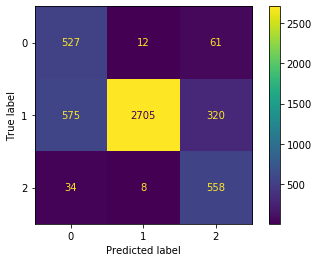

In [231]:
plot_confusion_matrix(svmc, X, y)

### Predicting on test set

In [323]:
svmc.fit(X, y)

SVC(C=0.6225, class_weight={0: 3.19, 1: 0.44444444, 2: 3.05},
    decision_function_shape='ovo', degree=6, gamma=0.057, random_state=77)

In [324]:
X_new = pd.read_csv('./data/X_test.csv')
X_new = X_new.drop(['id'], axis=1)
X_new = scaler.transform(X_new)

In [325]:
tuned_svc = svmc.predict(X_new)

In [326]:
ID = np.array(range(len(X_new)))
df = pd.DataFrame({'id': ID,
                    'y': tuned_svc})
name = '01_319_04_305.csv'
path = os.path.join('.', name)
df.to_csv(path, index=False)

### Result

| BMAC scores | |
:- | :-
hard baseline | 0.7
public test set | 0.7237
private test set | 0.6999